In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import randint
from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit, train_test_split

df = pd.read_csv("./mental-heath-in-tech-2016_20161114.csv")

pd.set_option('max_colwidth', 300)
pd.set_option('max_columns', 65)

# Information

df.info() for overview (use the cell below)

# Data Preparing

Handle missing entries, drop unwanted data and encode everything to numbers.  
 - drop self-employed because its a smaller fraction and more questions are targeted at employed people. 
 - drop 16-23 because they are directed at self-employed people.  
 - drop columns with too many choices
     - free text field, countries, specific work position and conditions
 - drop 3 because survey is directed at people in IT and we want to analyze this here
 - drop 0 (self employed) because now there is just one value

In [3]:
# Drop unwanted data

# Drop all self-employed as we only want to analyze people in companies.
df = df.drop(df[(df.iloc[:,0] == 1)].index)

# Drop 24 - 35 because we want to analyze the answers related to their current job.
# Drop questions for only self-employed people
df = df.drop(df.columns[list(range(16, 24))], axis = 1)

# Check what columns have too many choices
for ind, column in enumerate(df.columns):
    if len(df.iloc[:, ind].value_counts()) > 20:
        print(ind, column)
        print('Different answers: ', len(df[column].value_counts()))

# 35, 36  stay, rest goes (after analyzing)
# Drop the rest [37, 39, 48, 49, 51, 58, 60, 61]:
# df = df.drop(df.columns[[17, 19, 28, 29, 31, 37, 38, 39, 40, 41]], axis = 1)
df = df.drop(df.columns[[29, 31, 40, 41, 43, 49, 50, 51, 52, 53]], axis = 1)

# Drop 3 because this survey is directed at people in IT and we just care about that.
df = df.drop(df[(df.iloc[:,3] == 0)].index)
df = df.drop(df.columns[[3]], axis = 1)

# Drop self-employed because all the same
df = df.drop(df.columns[[0]], axis = 1)

# almost empty but we will just replace the non-present values with n/a (and after that -1)
# df = df.drop(["Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?"], axis=1)

29 Why or why not?
Different answers:  863
31 Why or why not?.1
Different answers:  860
40 If yes, what condition(s) have you been diagnosed with?
Different answers:  101
41 If maybe, what condition(s) do you believe you have?
Different answers:  77
43 If so, what condition(s) were you diagnosed with?
Different answers:  90
47 What is your age?
Different answers:  51
48 What is your gender?
Different answers:  61
49 What country do you live in?
Different answers:  43
50 What US state or territory do you live in?
Different answers:  47
51 What country do you work in?
Different answers:  44
52 What US state or territory do you work in?
Different answers:  48
53 Which of the following best describes your work position?
Different answers:  180


In [4]:
# Prepare Gender
male = ['Male', 'male', 'Male ', 'M', 'm', 'man', 'Cis male', 'Male.', 'Male. ', 'Male (cis)', 'Man', 'Sex is male',
        'cis male', 'Malr', 'Dude', 'mail', 'M|', 'male ', 'Cis Male', 'cisdude', 'cis man', 'MALE',
        "I'm a man why didn't you make this a drop down question. You should of asked sex? And I would of answered yes please. Seriously how much text can this take? "]
female = ['Female', 'female', 'I identify as female.', 'female ', 'Female assigned at birth ', 'F', 'Woman', 'f',
          'Cis female ', 'Female ', 'woman', 'female/woman', 'Cisgender Female', 'fem', 'Female (props for making this a freeform field, though)',
          ' Female', 'Cis-woman']
other = ['Bigender', 'non-binary', 'fm', 'Transitioned, M2F', 'Genderfluid (born female)', 'Other/Transfeminine',
         'Female or Multi-Gender Femme', 'Androgynous', 'male 9:1 female, roughly', 'Other', 'nb masculine',
         'none of your business', 'genderqueer', 'Human','Genderfluid', 'Enby','genderqueer woman', 'mtf', 'Queer',
         'Agender', 'Fluid', 'Male/genderqueer', 'Nonbinary', 'human', 'Unicorn', 'Male (trans, FtM)',
         'Genderqueer', 'Genderflux demi-girl', 'female-bodied; no feelings about gender', 'AFAB', 'Transgender woman', 'nan']

df["What is your gender?"].replace(male, 'male', inplace=True)
df["What is your gender?"].replace(female, 'female', inplace=True)
df["What is your gender?"].replace(other, 'other', inplace=True)
df["What is your gender?"].fillna('other', inplace=True);

df["What is your gender?"].unique()

array(['male', 'female', 'other'], dtype=object)

In [5]:
# Prepare Age 

# replace irregularities with mean age
mean = df["What is your age?"].mean()
mean = round(mean)
df.loc[(df["What is your age?"] < 15) | (df["What is your age?"] > 90),"What is your age?"] =  mean

df["What is your age?"].unique()

# scaler = MinMaxScaler()
# df['What is your age?'] = scaler.fit_transform(df[['What is your age?']])

# age in groups and ordinal
# age_labels = ["17-25", "26-34", "35-44", "45-54", "over 55"]
# df["What is your age?"] = pd.cut(x=df['What is your age?'], bins=[0,25,34,44,54,100], labels=age_labels)
# age_group_mapper = {'17-25':1, '26-34':2, '35-44':3, '45-54':4, 'over 55':5}
# df["What is your age?"] = df["What is your age?"].replace(age_group_mapper)

array([39, 29, 38, 43, 42, 30, 37, 44, 28, 34, 35, 52, 32, 31, 26, 25, 33,
       27, 36, 40, 46, 41, 45, 21, 24, 17, 23, 51, 22, 49, 20, 54, 47, 56,
       50, 55, 57, 61, 19, 48, 62, 53, 58, 66, 59, 63, 70], dtype=int64)

In [6]:
# Clean Data
# 44: Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?
# around 500 did not answer -> not applicable
df["Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?"].fillna('n/a', inplace=True)

# We interpret the answer n/a here as no [4. Does your employer provide mental health benefits as part of healthcare coverage?]
# Everyone should be applicable here.
# df["Does your employer provide mental health benefits as part of healthcare coverage?"].replace('Not eligible for coverage / N/A', 'No', inplace=True)

# fillna here with maybe (TODO reevaluate) 
# df['obs_reveal'].fillna('Maybe', inplace=True)

# Don't mind above, all nan will be replaced with -1/'nan'

In [7]:
# shorten column names
df = df.rename(columns = {'How many employees does your company or organization have?'
                          :'company_size'})
df = df.rename(columns = {'Is your employer primarily a tech company/organization?'
                          :'primarily_tech'})
df = df.rename(columns = {'Does your employer provide mental health benefits as part of healthcare coverage?'
                          :'empl_healthcare'})
df = df.rename(columns = {'Do you know the options for mental health care available under your employer-provided coverage?'
                          :'empl_aware_healthcare'})
df = df.rename(columns = {'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?'
                          :'empl_formal_discuss'})
df = df.rename(columns = {'Does your employer offer resources to learn more about mental health concerns and options for seeking help?'
                          :'empl_ressources'})
df = df.rename(columns = {'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?'
                          :'empl_anon'})
df = df.rename(columns = {'If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:'
                          :'mh_leave'})
df = df.rename(columns = {'Do you think that discussing a mental health disorder with your employer would have negative consequences?'
                          :'empl_discuss_mh_cons'})
df = df.rename(columns = {'Do you think that discussing a physical health issue with your employer would have negative consequences?'
                          :'empl_discuss_ph_cons'})
df = df.rename(columns = {'Would you feel comfortable discussing a mental health disorder with your coworkers?'
                          :'cowo_discuss'})
df = df.rename(columns = {'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?'
                          :'sup_discuss'})
df = df.rename(columns = {'Do you feel that your employer takes mental health as seriously as physical health?'
                          :'empl_mh_serious'})
df = df.rename(columns = {'Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?'
                          :'cowo_cons_open'})
# previous employees
df = df.rename(columns = {'Do you have previous employers?'
                          :'pempl'})
df = df.rename(columns = {'Have your previous employers provided mental health benefits?'
                          :'pempl_healthcare'})
df = df.rename(columns = {'Were you aware of the options for mental health care provided by your previous employers?'
                          :'pempl_aware_healthcare'})
df = df.rename(columns = {'Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?'
                          :'pempl_formal_discuss'})
df = df.rename(columns = {'Did your previous employers provide resources to learn more about mental health issues and how to seek help?'
                          :'pempl_ressources'})
df = df.rename(columns = {'Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?'
                          :'pempl_anon'})
###
df = df.rename(columns = {'If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:'
                          :'mh_leave'})
###
df = df.rename(columns = {'Do you think that discussing a mental health disorder with previous employers would have negative consequences?'
                          :'pempl_discuss_mh_cons'})
df = df.rename(columns = {'Do you think that discussing a physical health issue with previous employers would have negative consequences?'
                          :'pempl_discuss_ph_cons'})
df = df.rename(columns = {'Would you have been willing to discuss a mental health issue with your previous co-workers?'
                          :'pcowo_discuss'})
df = df.rename(columns = {'Would you have been willing to discuss a mental health issue with your direct supervisor(s)?'
                          :'psup_discuss'})
df = df.rename(columns = {'Did you feel that your previous employers took mental health as seriously as physical health?'
                          :'pempl_mh_serious'})
df = df.rename(columns = {'Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?'
                          :'pcowo_cons_open'})
#
df = df.rename(columns = {'Would you be willing to bring up a physical health issue with a potential employer in an interview?'
                          :'ph_interview'})
df = df.rename(columns = {'Would you bring up a mental health issue with a potential employer in an interview?'
                          :'mh_interview'})
df = df.rename(columns = {'Do you feel that being identified as a person with a mental health issue would hurt your career?'
                          :'hurt_career'})
df = df.rename(columns = {'Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?'
                          :'cowo_neg_think'})
df = df.rename(columns = {'How willing would you be to share with friends and family that you have a mental illness?'
                          :'friends_family'})
df = df.rename(columns = {'Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?'
                          :'cowo_cons_observ'})
df = df.rename(columns = {'Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?'
                          :'bad_response'})
df = df.rename(columns = {'Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?'
                          :'obs_reveal'})
df = df.rename(columns = {'Do you have a family history of mental illness?'
                          :'mh_family'})
df = df.rename(columns = {'Have you had a mental health disorder in the past?'
                          :'mh_past'})
df = df.rename(columns = {'Do you currently have a mental health disorder?'
                          :'mh_currently'})
df = df.rename(columns = {'Have you been diagnosed with a mental health condition by a medical professional?'
                          :'diagnosed'})
df = df.rename(columns = {'Have you ever sought treatment for a mental health issue from a mental health professional?'
                          :'sought_treatment'})
df = df.rename(columns = {'If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?'
                          :'mh_interference_treated'})
df = df.rename(columns = {'If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?'
                          :'mh_interference_not_treated'})
df = df.rename(columns = {'What is your age?'
                          :'age'})
df = df.rename(columns = {'What is your gender?'
                          :'gender'})
df = df.rename(columns = {'Do you work remotely?'
                          :'remote'})

In [8]:
# Functions for mappers
def get_mapper(values):
    for mapper in mapper_list:
        if compare_arrays(values, mapper):
            return mapper


def compare_arrays(arr1, arr2):
    count = 0
    for val in arr1:
        if val in arr2:
            count+=1
    if count == arr1.size:
        return True
    else:
        return False

In [9]:
# make all features numerical (except gender, see at the end)
# Negative: 1, the more positive the higher. n/a and nan will be encoded as -1

mapper_list = [{'No':1, 'Maybe':2, 'Yes':3}, {'No':1, 'I don\'t know':2, 'Yes':3}, {'No, it has not':1, 'No, I don\'t think it would':2,'Maybe':3, 'Yes, I think it would':4, 'Yes, it has':5},
               {'None of them':1,  'I don\'t know':3, 'Some of them':2, 'Yes, all of them':4}, {'None did':1, 'Some did':2, 'Yes, they all did':3}, 
               {'No':1, 'Maybe/Not sure':2, 'Yes, I observed':3, 'Yes, I experienced':4},
               {'N/A (not currently aware)':1, 'No, I only became aware later':2, 'I was aware of some':3, 'Yes, I was aware of all of them':4},
               {'No, they do not':1, 'No, I don\'t think they would':2, 'Maybe':3, 'Yes, I think they would':4, 'Yes, they do':5},
               {'Very difficult':1, 'Somewhat difficult':2, 'Neither easy nor difficult':3, 'Somewhat easy':4, 'Very easy':5, 'I don\'t know':3},
               {'Not open at all':1, 'Somewhat not open':2, 'Neutral':3, 'Not applicable to me (I do not have a mental illness)': -1, 'Somewhat open':4, 'Very open':5},
               {'Never':1, 'Sometimes':2, 'Always':3},
               {'No':1, "I'm not sure":2, 'Yes': 3},
               {'No, at none of my previous employers':1, 'I don\'t know': 2, 'Some of my previous employers':3, 'Yes, at all of my previous employers':4},
               {'None did':1, "I don't know":2, 'Some did':3,  'Yes, they all did':4},
               {'No, none did':1, "I don't know":2, 'Some did':3, 'Yes, they all did':4},
               {'None of them':1, "I don't know":2, 'Some of them':3, 'Yes, all of them':4},
               {'None did':1, 'Some did':2, 'Yes, they all did':3},
               {'No, none did':1, "I don't know":2, 'Some did':3, 'Yes, they all did':4},
               {'No, none did':1, "I don't know":2, 'Some did':3, 'Yes, they all did':4},
               {'No, at none of my previous employers':1, "I don't know":2, 'Some of my previous employers':3, 'Yes, at all of my previous employers':4},
               {'No':1, "I don't know":2, 'Sometimes':3, 'Yes, always':4},
               {'Never':1, 'Rarely':2, 'Not applicable to me':-1, 'Sometimes':3, 'Often':4},
               {'Never':1, 'Rarely':2, 'Sometimes':3, 'Often':4},
               {'No':1, 'I don\'t know':2, 'Yes':3, 'Not eligible for coverage / N/A': -1},
               {'No':1, "I am not sure":2, 'Yes': 3, 'nan': -1},
               {'No':1, 'Maybe':2, 'Yes':3, 'n/a':-1},
               {0:1, 1:2},
               {'1-5':1, '6-25':6, '26-100':26, '100-500':100, '500-1000':500, 'More than 1000':1000}]

# Haven't figured out why, but needs to be done twice   
for column in df:
    df[column] = df[column].replace(get_mapper(df[column].unique()))

for column in df:
    df[column] = df[column].replace(get_mapper(df[column].unique()))

# Fill al nan with -1 as not applicable (just one feature)
df = df.fillna('nan')

for column in df:
    df[column] = df[column].replace(get_mapper(df[column].unique()))

# make own features for 2 of the gender options, if both are 0, it is the third.
df = pd.get_dummies(df, dummy_na=False, drop_first=True);


In [10]:
# Plots the feature importance of a given model and prints depth and score
def feature_importance(model, depth, score):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(10).plot(kind='barh', title='Depth: ' + str(depth) + ' Score: ' + str(score))

In [11]:
# Hyper parameter tuning (define this later when we actually start using this.)
# By using predefined splits we cannot use the best estimator we get here, we need to either do everything we want to do with it here,
# or just use the parameters and create it again below
# pds is either the predefined split or the cross-validation number
def tune_parameters(model, pds, parameters, scoring):
    # 100k works for now, 235k would make more sense though (all possible combinations)
    search = RandomizedSearchCV(model, parameters, n_iter=100000, cv=pds, scoring=scoring, refit=True, n_jobs=-1, random_state=42, verbose=10)
    search.fit(X, y)
    val_predictions = search.best_estimator_.predict(val_X)
    score = accuracy_score(val_predictions, val_y)
    print('best score: ', search.best_score_)
    print('best parameters: ', search.best_params_)
    print('prediction score: ', score)
    print(classification_report(val_y, val_predictions))
    feature_importance(search.best_estimator_, 'Check above', score)
    tree_rules = export_text(search.best_estimator_, feature_names=list(X))
    text_file = open("tree_rules.txt", "w")
    text_file.write(tree_rules)
    text_file.close()
    
    fig=plt.figure(figsize=(40, 40))
    plot_tree(search.best_estimator_, fontsize=8, feature_names=list(X), filled=True)
    fig.savefig('decision_tree_plot.png', dpi=100)

# Selecting the training data

First select the various targets we'd like to classify, then remove obvious affectors from the features.
Split the training data with random_state so we don't see different results for different splits.

## Targets:

It's interesting whether we can detect if a person would bring up mental health issues with employers in an interview and why.  
compare with damage career, affect on work  
mh_interview = Would you bring up a mental health issue with a potential employer in an interview?  

Why does a person not seek treatment?  
sought_treatment = Have you ever sought treatment for a mental health issue from a mental health professional?  

We dont include diagnosed in our features as it directly indicates someone has sought treatment.  
Interview will be checked in Results/Exploring as we compare a naive approach with hyper paramter tuning here.

In [15]:
test_size = 0.25

# X and Y
y_interview = "mh_interview"
y_treatment = "sought_treatment"
# high_affectors = ["ph_interview"]


X = df.drop([y_treatment, "diagnosed"], axis=1, inplace=False)
y = df[y_treatment]

# Split Data to Train and Validation
train_X , val_X , train_y , val_y = train_test_split(X, y, test_size = test_size, random_state=69)

# Create a list where train data indices are -1 and validation data indices are 0
split_index = [-1 if x in train_X.index else 0 for x in X.index]

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

## Naive approach

Iterate over depth and select the model with the best result.

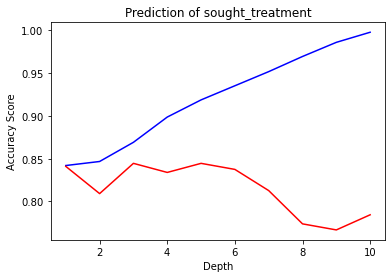

              precision    recall  f1-score   support

           1       0.86      0.78      0.82       127
           2       0.83      0.90      0.86       156

    accuracy                           0.84       283
   macro avg       0.85      0.84      0.84       283
weighted avg       0.85      0.84      0.84       283



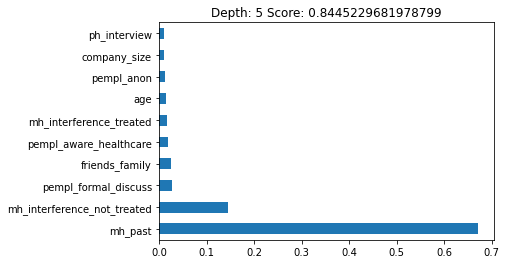

In [16]:
maxdepth = 10

t_acc =[0]* maxdepth
v_acc =[0]* maxdepth

bestdepth = 1
best_model = None
bestscore = 0

for depth in range(1,maxdepth +1):
    # Specify Model
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    # FitModel
    clf.fit(train_X , train_y)
    # calculate mean absolute error on training instances 
    train_predictions = clf.predict(train_X)
    t_acc[depth - 1] = accuracy_score(train_predictions, train_y)
    # Make validation predictions and calculate mean absoluteerror
    val_predictions = clf.predict(val_X)
    v_acc[depth - 1] = accuracy_score(val_predictions, val_y)
    
    if(v_acc[depth - 1] >= v_acc[bestdepth - 1]):
        best_model = clf
        bestdepth = depth
        bestscore = v_acc[depth - 1]

t_acc = np.asarray(t_acc)
v_acc = np.asarray(v_acc)

plt.plot(range(1,maxdepth +1),t_acc ,c="blue")
plt.plot(range(1,maxdepth +1),v_acc ,c="red")
plt.xlabel('Depth')
plt.ylabel('Accuracy Score')
plt.title('Prediction of ' + y.name)

plt.show()

feature_importance(best_model, bestdepth, bestscore)
val_predictions = best_model.predict(val_X)
print(classification_report(val_y, val_predictions))

## Analyze Results for better models

Here we should find out what features should be dropped because they affect the results too much. (or something like that)  
Then we run it again with the changes. We will at first maybe don't change the data at all by dropping more than neccessary and just see how much hear changes and we will talk step by step  
what we remove and why. We won't show results in between, just the end results.  

After that we try applying hyper parameter tuning. This should achieve better results. We use predefined splits for cross-validation so we can better compare it to the naive approach.  
The way the training data is split does make a huge difference and that is why the naive approach could sometimes get better results. (maybe increasing the iterations + cv will avoid this, but it takes much longer time then.)  
Of course it would make more sense to not use presplit data, but for the sake of comparison to naive approaches I did it like this. After comparing the approaches, we will switch to cross validation in the hyper-parameter tuning. 

### Actual Results to analyze

based on feature importance and general making sense:  
- mh_past seems to have way too high influence. => drop (90%+)  
- mh_interference_treated, mh_interference_not_treated in some way also imply treatment so => drop (70%+)   
- mh_currently also may have too much influence. Also: If we drop mh_past, we might as well drop currently, no? If you think otherwise, lets change it, or change it yourself.  
  in parameter tuned way higher feature importance so by then, definitly => drop (60%+)

In [25]:
# Here talk about changes or do them here. (makes more sense to just put them where they belong and just mention the changes done here)
# Then just apply the test above again.

high_affectors = ["mh_past", "mh_currently", "mh_interference_treated", "mh_interference_not_treated", "diagnosed"]

X = df.drop([y_treatment] + high_affectors, axis=1, inplace=False)
y = df[y_treatment]

# Split Data to Train and Validation
train_X , val_X , train_y , val_y = train_test_split(X, y, test_size = test_size, random_state=69)

# Create a list where train data indices are -1 and validation data indices are 0
split_index = [-1 if x in train_X.index else 0 for x in X.index]

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

### Redo the naive approach with better feature selection

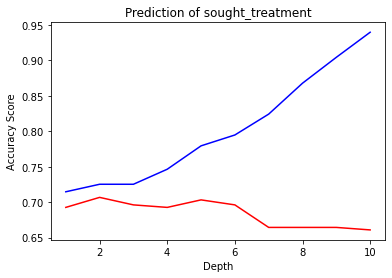

              precision    recall  f1-score   support

           1       0.77      0.50      0.60       127
           2       0.68      0.88      0.77       156

    accuracy                           0.71       283
   macro avg       0.72      0.69      0.69       283
weighted avg       0.72      0.71      0.69       283



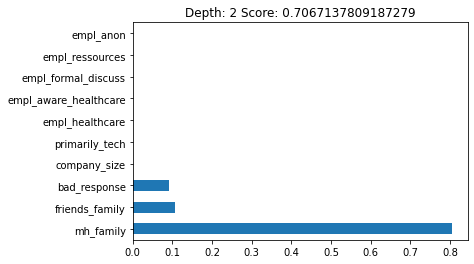

In [26]:
maxdepth = 10

t_acc =[0]* maxdepth
v_acc =[0]* maxdepth

bestdepth = 1
best_model = None
bestscore = 0

for depth in range(1,maxdepth +1):
    # Specify Model
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    # FitModel
    clf.fit(train_X , train_y)
    # calculate mean absolute error on training instances 
    train_predictions = clf.predict(train_X)
    t_acc[depth - 1] = accuracy_score(train_predictions, train_y)
    # Make validation predictions and calculate mean absoluteerror
    val_predictions = clf.predict(val_X)
    v_acc[depth - 1] = accuracy_score(val_predictions, val_y)
    
    if(v_acc[depth - 1] >= v_acc[bestdepth - 1]):
        best_model = clf
        bestdepth = depth
        bestscore = v_acc[depth - 1]

t_acc = np.asarray(t_acc)
v_acc = np.asarray(v_acc)

plt.plot(range(1,maxdepth +1),t_acc ,c="blue")
plt.plot(range(1,maxdepth +1),v_acc ,c="red")
plt.xlabel('Depth')
plt.ylabel('Accuracy Score')
plt.title('Prediction of ' + y.name)

plt.show()

feature_importance(best_model, bestdepth, bestscore)
val_predictions = best_model.predict(val_X)
print(classification_report(val_y, val_predictions))

## Apply Hyper parameter tuning

Talk about what hyper parameter tuning is, why we use the selected parameters and then do it.  
This is defined way above and could be moved here.

Fitting 1 folds for each of 100000 candidates, totalling 100000 fits
best score:  0.7703180212014135
best parameters:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 23, 'min_samples_leaf': 6, 'min_samples_split': 13}
prediction score:  0.7985865724381626
              precision    recall  f1-score   support

           1       0.78      0.76      0.77       127
           2       0.81      0.83      0.82       156

    accuracy                           0.80       283
   macro avg       0.80      0.80      0.80       283
weighted avg       0.80      0.80      0.80       283



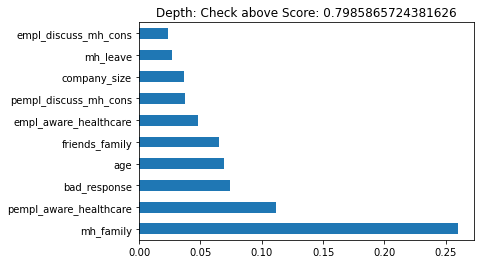

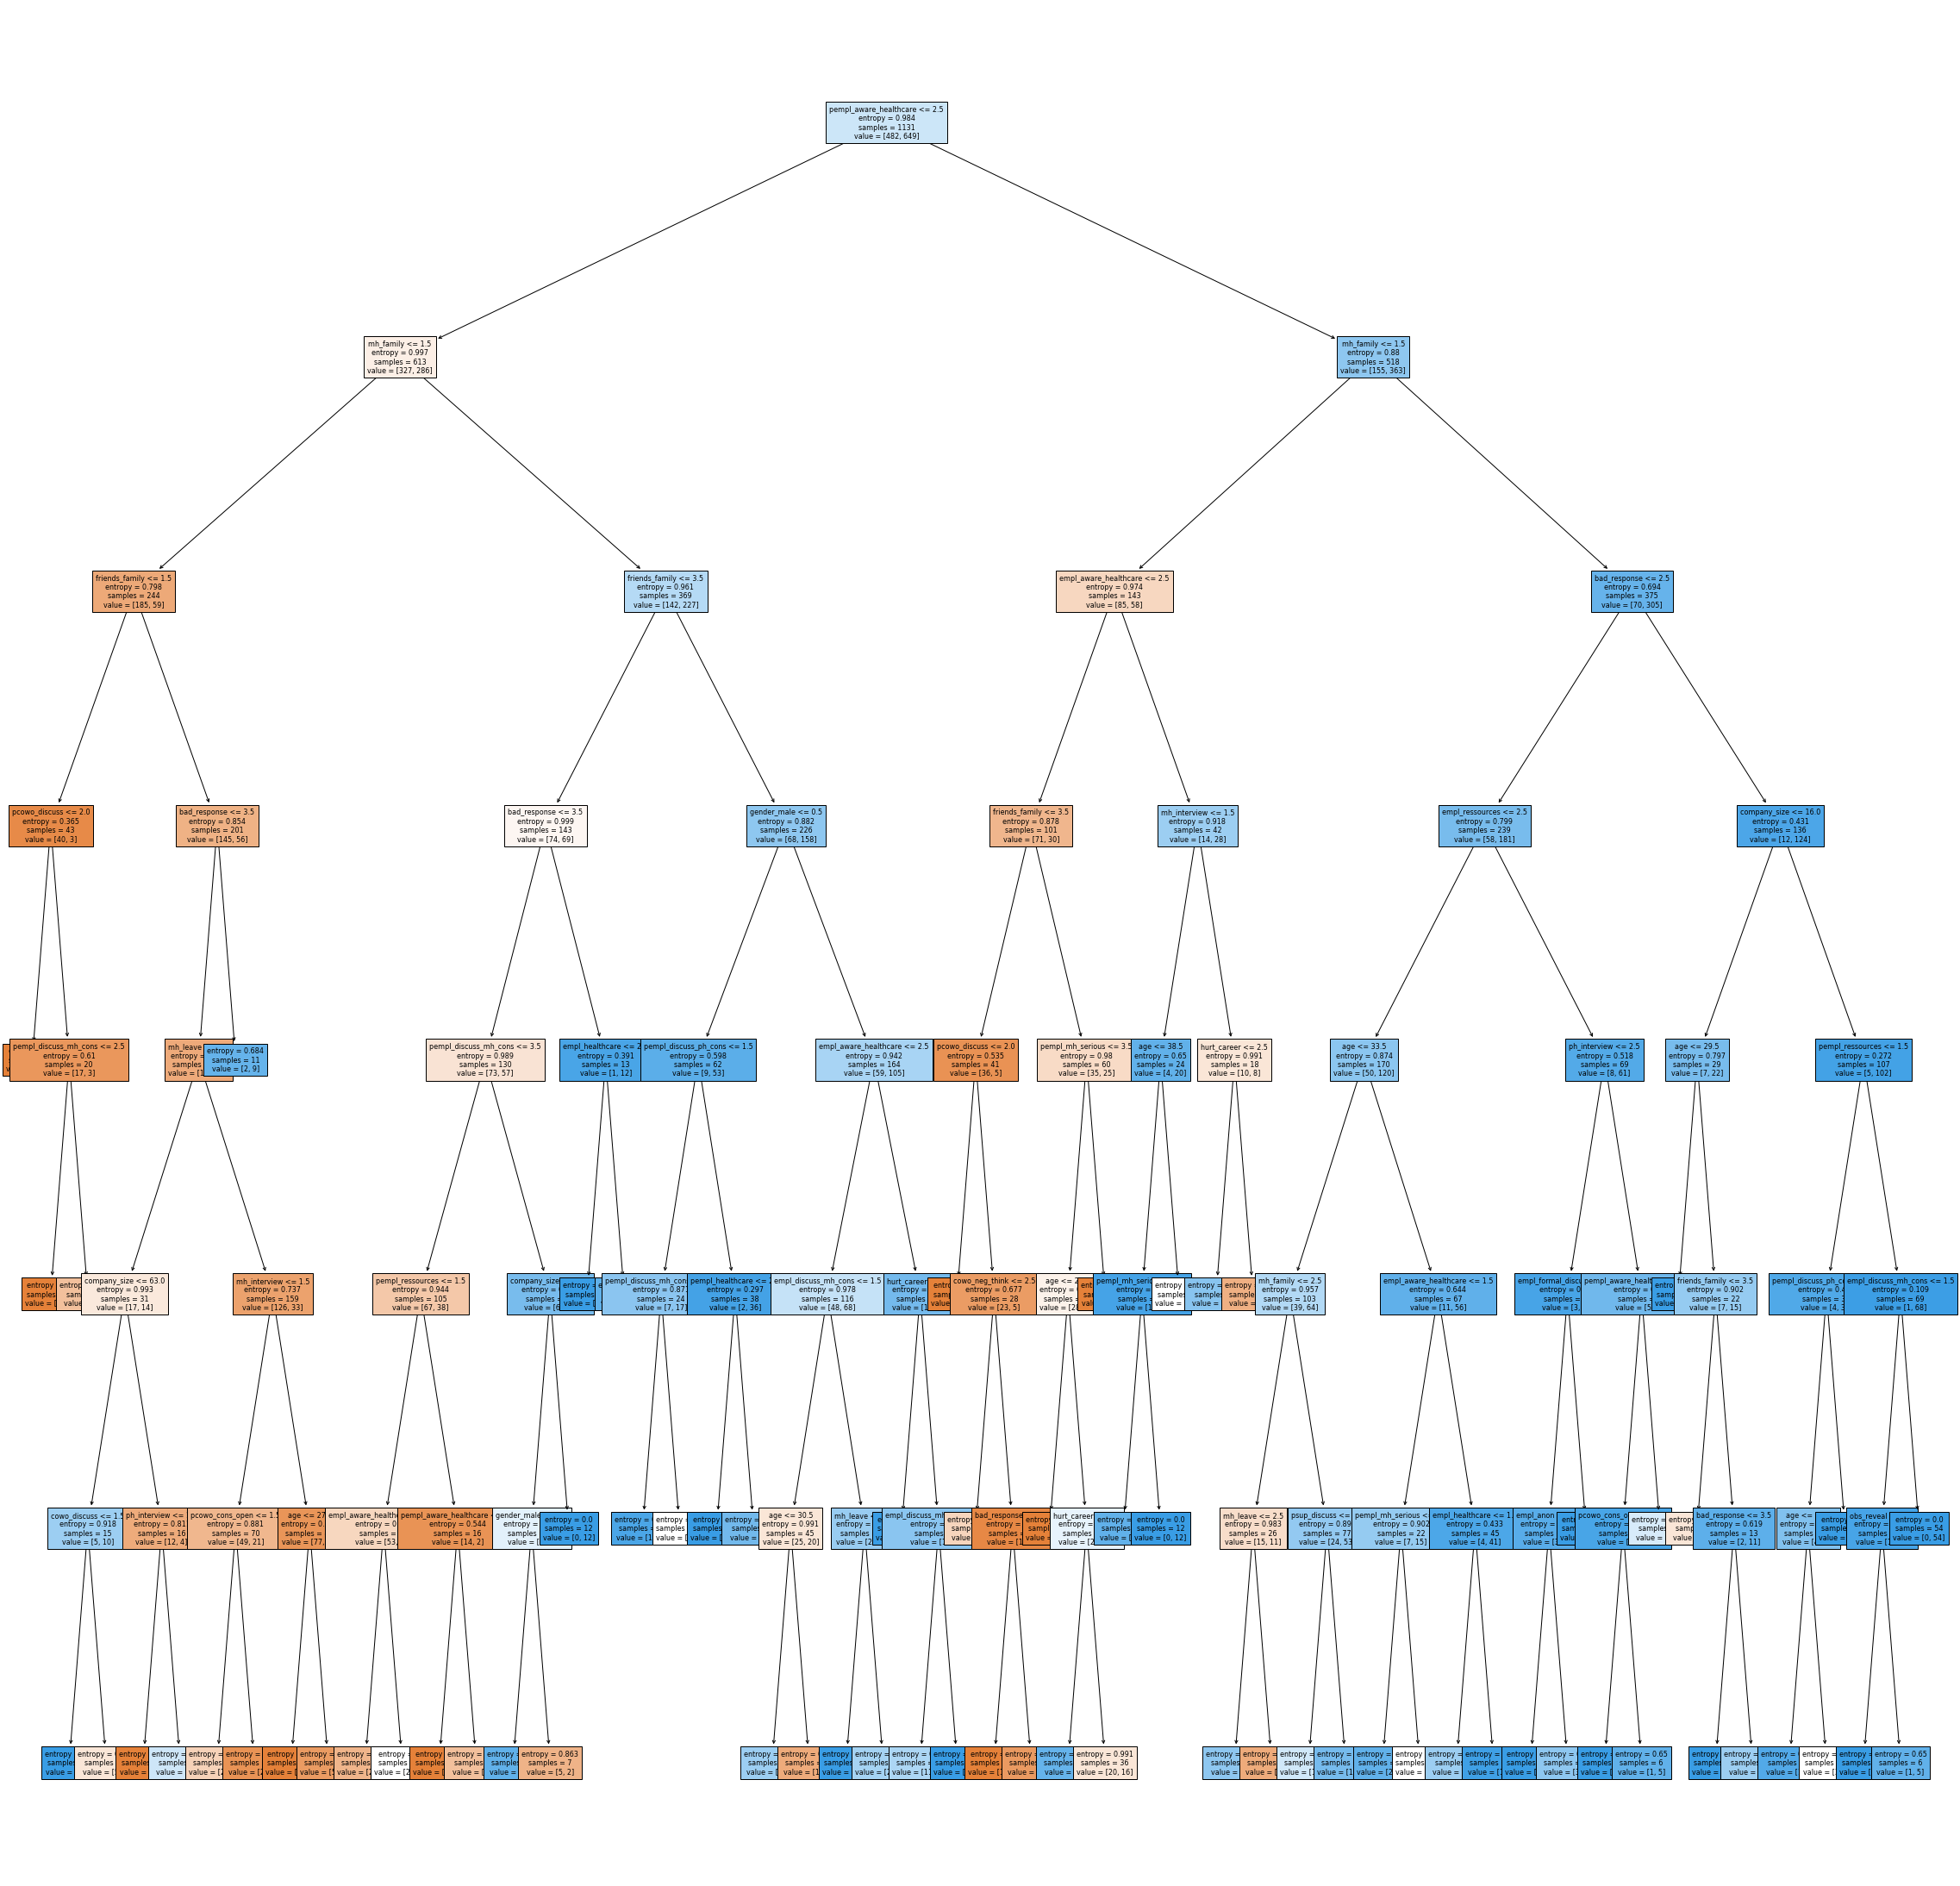

In [27]:
featureSize = len(X.columns)

scoring_clf = 'accuracy'

param_dist_class = {
    "max_depth": randint(3,10),
    "max_features": randint(10, featureSize),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 20),
    "criterion": ["gini", "entropy"]}

# class_weight="balanced"

clf = DecisionTreeClassifier(random_state=42)
tune_parameters(clf, pds, param_dist_class, scoring_clf)

## Apply Hyper-parameter tuning with cross-validation

So far we just applied the DecisionTreeClassifier to a predefined split so we could compare the classifier with and without parameter tuning. To actually get really useful results, we should apply  
it to no predefined split. By cross-validation it will no longer learn specifically for that split.  

In [ ]:
from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report, confusion_matrix, roc_curve, auc


clf = DecisionTreeClassifier(random_state=42)
# pass cv count. 
tune_parameters(clf, 20, param_dist_class, scoring_clf)

Fitting 20 folds for each of 100000 candidates, totalling 2000000 fits


## Results/More Exploring

Check the results. What can we learn from the resulting tree?  

Check y_interview!

## Advantages of DecisionTree

Here we can show the advantage of the DecisionTreeClassifier compared to for example the RandomForestClassifier.  
We can print the rules of the tree, as well as plot the tree itself and there we can see how the model decides.

In [ ]:
# Output rules to txt
# tree_rules = export_text(clf, feature_names=list(X))
# text_file = open("Output.txt", "w")
# text_file.write(tree_rules)
# text_file.close()

# fig=plt.figure(figsize=(40, 40))
# tree.plot_tree(clf, fontsize=8, feature_names=list(X), filled=True)
# fig.savefig('decision_tree_plot.png', dpi=100)

df["mh_interview"].value_counts()

In [ ]:
# Age plot (More of a template now)
# plt.figure(figsize=(15,8))
# plt.title("Age Distribution and Density")
# plt.xlabel("Age")
# plt.ylabel("Density")
# sns.distplot(df['What is your age?'])

In [ ]:
# RandomForest for comparison maybe

featuresSize = len(X.columns)
scoring_clf = 'accuracy'

param_dist_class = {
    "max_depth": randint(3,10),
    "max_features": randint(1, featuresSize),
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 10),
    "criterion": ["gini", "entropy"]}

clf2 = RandomForestClassifier(n_estimators=200, random_state=42)  
# tune_parameters(clf2, param_dist_class, scoring_clf)
clf2.fit(train_X, train_y)  
val_predictions = clf2.predict(val_X)
score = accuracy_score(val_predictions, val_y)
feature_importance(clf2, 200, score)
clf2.score(X, y)

## Questions

0. Are you self-employed?
1. How many employees does your company or organization have? **[NaN]**
2. Is your employer primarily a tech company/organization? **[NaN]**
3. Is your primary role within your company related to tech/IT? **[NaN]**
4. Does your employer provide mental health benefits as part of healthcare coverage?
5. Do you know the options for mental health care available under your employer-provided coverage?
6. Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?
7. Does your employer offer resources to learn more about mental health concerns and options for seeking help?
8. Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
9. If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:
10. Do you think that discussing a mental health disorder with your employer would have negative consequences?
11. Do you think that discussing a physical health issue with your employer would have negative consequences?
12. Would you feel comfortable discussing a mental health disorder with your coworkers?
13. Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?
14. Do you feel that your employer takes mental health as seriously as physical health?
15. Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?
36. Would you be willing to bring up a physical health issue with a potential employer in an interview?
38. Would you bring up a mental health issue with a potential employer in an interview? **[NaN]**
40. Do you feel that being identified as a person with a mental health issue would hurt your career? **[NaN]**
41. Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue? **[NaN]**
42. How willing would you be to share with friends and family that you have a mental illness? **[NaN]**
43. Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace? **[NaN]**
44. Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace? **[NaN]**
45. Do you have a family history of mental illness?
46. Have you had a mental health disorder in the past? **[NaN]**
47. Do you currently have a mental health disorder? **[NaN]**
50. Have you been diagnosed with a mental health condition by a medical professional? **[NaN]**
52. Have you ever sought treatment for a mental health issue from a mental health professional?
53. [FOLLOW-UP] If you have a mental health issue, do you feel that it interferes with your work when being treated effectively? **[NaN]**
54. [FOLLOW-UP] If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?
55. What is your age?
56. What is your gender?
62. Do you work remotely?

In [ ]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:", accuracy_score(val_y, y_pred))

In [ ]:
# already in matrix I'd guess

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(val_y, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(val_y, y_pred))